This notebook is designed to be run after another notebook $load_data_w_EDA.ipynb$ which was included in this submission. 

# Hailey Weinschenk - BrainStation Capstone Notebook 2 - Binary Classification 

We will aim to use logistic regression to solve a binary classification problem. More specifically, our models should reliably be able to classify an image of a single playing card as either a red (Hearts or Diamonds) or black (Spades or Clubs). However, instead of classifying as black, we simply classify as not red.

Firstly, we import our functions and libraries necessary. $preprocess.py$ is also included in this submission and should be in the same present working directory as this notebook. This .py file contains the preprocessing functions necessary. Then standard data science libraries, numpy, matplotlib, and pandas are utilized as well. 

In [1]:
from preprocess import preprocess
from helpers import print_accuracy
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
import os.path
import sys

Due to the large size of our images, we utilize the `chunksize` and `iterator` parameters of *pandas.read_csv()*. Then the results are concatenated. This allows us to read in a large df with less memory used. In one test, this downsided the RAM used from 25 GB to 10. Since the DataFrame is contained in memory throughout, this leaves more leeway for modelling. 

In [2]:
if( os.path.exists('full_preprocessedML.csv')):
    df_chunk = pd.read_csv('full_preprocessedML.csv',index_col=0,iterator=True,chunksize=250)
    df = pd.concat(df_chunk)
else:
    sys.exit("Please run load_data_w_EDA.ipynb then rerun this notebook.")    
    

Firstly, we can view our data.

In [3]:
df.head()

,img_card_arr,card_class,pixel_0,pixel_1,pixel_2,pixel_3,pixel_4,pixel_5,pixel_6,pixel_7,...,pixel_186618,pixel_186619,pixel_186620,pixel_186621,pixel_186622,pixel_186623,suit,is_red,suit_num,card_number
0,[15 15 15 ... 3 3 3],10 of Hearts,15,15,15,10,16,15,14,14,...,4,4,4,3,3,3,Hearts,1,2,34
1,[11 16 15 ... 0 5 4],Ace of Hearts,11,16,15,15,19,18,11,16,...,6,7,8,0,5,4,Hearts,1,2,38
2,[18 17 19 ... 21 21 51],2 of Clubs,18,17,19,17,20,21,12,17,...,30,41,70,21,21,51,Clubs,0,1,13
3,[11 15 16 ... 6 5 7],Queen of Spades,11,15,16,13,17,18,12,16,...,10,9,11,6,5,7,Spades,0,3,49
4,[11 15 16 ... 4 6 6],Queen of Clubs,11,15,16,11,14,19,9,14,...,7,9,10,4,6,6,Clubs,0,1,23


# Logistic Regression for Binary Classification

We are ready to begin the machine learning modelling. A necessary precursor to model building is to define our features or independent variables, denoted X, and our target, or dependent variables, denoted y. In this case, we simply want our features to be the ~180,000 pixels from each of our 216X288x3 images. Our target is simply red/not red.

In [4]:
X = df.iloc[:,2:-4] #split the df into only pixels
y = df['is_red'] # target is the column 'is_red'

And we can view our DataFrames:

In [5]:
y.head() # 0 denotes not red (black), 1 denotes red

0    1
1    1
2    0
3    0
4    0
Name: is_red, dtype: int64

In [6]:
X.head() # df full of pixels

,pixel_0,pixel_1,pixel_2,pixel_3,pixel_4,pixel_5,pixel_6,pixel_7,pixel_8,pixel_9,...,pixel_186614,pixel_186615,pixel_186616,pixel_186617,pixel_186618,pixel_186619,pixel_186620,pixel_186621,pixel_186622,pixel_186623
0,15,15,15,10,16,15,14,14,14,16,...,3,3,3,3,4,4,4,3,3,3
1,11,16,15,15,19,18,11,16,15,13,...,10,3,2,4,6,7,8,0,5,4
2,18,17,19,17,20,21,12,17,16,16,...,138,75,86,130,30,41,70,21,21,51
3,11,15,16,13,17,18,12,16,17,15,...,6,7,6,8,10,9,11,6,5,7
4,11,15,16,11,14,19,9,14,17,11,...,11,4,8,9,7,9,10,4,6,6


Our variables look correct! Now we can perform the train-test split. For this, we will take a test set size of 20%. After splitting, we can investigate potential scaling of our data. Scaling is used to regularize different aspects of the data if it is on different scales. For example, if one feature's range was 0-10, while another was 1m-10m. The easy part about working with image data is that scaling is entirely unnecessary since we are working with data within  0-255. However, we can normalize our data by dividing every element by 255. This converts our int data into floats.

In [7]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size = .2)
X_train/=255
X_test/=255 # our 'normalization'

In [8]:
X_test.head() # now it is all decimals

,pixel_0,pixel_1,pixel_2,pixel_3,pixel_4,pixel_5,pixel_6,pixel_7,pixel_8,pixel_9,...,pixel_186614,pixel_186615,pixel_186616,pixel_186617,pixel_186618,pixel_186619,pixel_186620,pixel_186621,pixel_186622,pixel_186623
1282,0.050980,0.050980,0.050980,0.050980,0.050980,0.050980,0.039216,0.039216,0.039216,0.039216,...,0.054902,0.050980,0.050980,0.050980,0.047059,0.043137,0.047059,0.039216,0.035294,0.043137
357,0.090196,0.101961,0.105882,0.101961,0.109804,0.113725,0.094118,0.101961,0.105882,0.098039,...,0.043137,0.050980,0.047059,0.054902,0.035294,0.031373,0.039216,0.047059,0.043137,0.050980
427,0.031373,0.027451,0.035294,0.031373,0.027451,0.035294,0.031373,0.027451,0.035294,0.031373,...,0.074510,0.070588,0.066667,0.074510,0.070588,0.066667,0.074510,0.070588,0.066667,0.074510
2058,0.047059,0.062745,0.066667,0.047059,0.066667,0.062745,0.047059,0.066667,0.062745,0.047059,...,0.023529,0.007843,0.015686,0.015686,0.039216,0.047059,0.050980,0.015686,0.031373,0.027451
447,0.023529,0.019608,0.027451,0.027451,0.023529,0.031373,0.019608,0.019608,0.019608,0.023529,...,0.329412,0.341176,0.333333,0.329412,0.345098,0.337255,0.337255,0.345098,0.337255,0.333333


Now we can initalize and fit our first model. This is the first instance of a common theme in predictive modelling in Python. $$Instantiate, Fit, Score$$

In [9]:
from sklearn.linear_model import LogisticRegression #import from SKLearn

#(I)nstantiate a model object
logit = LogisticRegression()

#(F)it the model on the training data
logit.fit(X_train,y_train)

#(S)core the model on the training and testing data
print_accuracy(logit,X_train,X_test,y_train,y_test)


Accuracy on the training set was 1.0
Accuracy on the test set was 0.7971014492753623




So our accuracy score is reasonable. Let's circle back to this...

Before doing this, we can examine the coefficients of each variable in our logit model which provide a high level of interpretation. Each coefficient is the measure of 'how much a one unit increase in a variable changes the odds ratio'. In this case, each feature is a pixel, so that means that these coefficients represent the extent to which a one unit in the pixel affects the odds a card is red or black. Let's demystify this with an example.

We can take all the coefficients and find the highest and lowest amounts. 

In [10]:
coefs = logit.coef_ # index pixel 0 coef pixel 1 coef... pixel x coef.
coefs.T.shape
coefsS = pd.Series(data = coefs.T.reshape(186624,),index = np.arange(0,186624))

print(f'Max coefficient value is {coefsS.max()} at pixel number {coefsS.idxmax()}')
print(f'Min coefficient value is {coefsS.min()} at pixel number {coefsS.idxmin()}')

Max coefficient value is 0.20295993415231245 at pixel number 91041
Min coefficient value is -0.18133236892445634 at pixel number 88438


So the max pixel increases the odds that a card is red while the min increases the odds that it is not red. Let's visualize these pixels on a sample image.

In [11]:
max_coef = coefsS.idxmax()# get the index (pixel number of the max and min coefs_)
min_coef = coefsS.idxmin()
x_max = max_coef/(288*3) # convert to x,y,z coordinates...
y_max = max_coef/(216*3)
x_min = min_coef/(288*3)
y_min = min_coef/(216*3)
x_max,y_max,x_min,y_min

(105.37152777777777, 140.49537037037038, 102.35879629629629, 136.4783950617284)

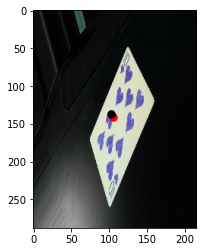

In [12]:
one_img = X.iloc[0,:].tolist()
one_img = np.array(one_img)
plt.imshow(one_img.reshape(288,216,3))
plt.plot(x_max,y_max,marker = '.',markersize = 15,color = 'red')
plt.plot(x_min,y_min,marker = '.',markersize = 15,color = 'black')

plt.show()

Both these pixels are in the center of our canvas which is to be expected! These center pixels are very likely to read a black or red symbol for each card.

After that brief aside, let us refocus on the accuracy score above. There are a few ways to try to improve this. There are numerous hyperparameters (or parameters set by the 'operator' to control the modelling process) such as the Lasso (L1) or Ridge (L2) penalties, solver type, as well as the C value which controls the strength of penalty. Due to memory constraints we cannot have a exhaustive search of all these parameters, rather we will search modest possibilities for the two most important: the penalty type and strength.

It is important to note that this gridsearch algorithm employs cross validation. This is a process of iteratively taking subsets of your training data to act as a validation set, rather than having one dedicated dataset for that purpose. As we will see more in the next notebook, the validation set is analogous to the testing set when setting hyperparameters. We do not want to leak data, meaning 'show' our real test set to the model before the testing stage.

In [13]:
from sklearn.model_selection import GridSearchCV

In [14]:
potential_c = [10**i for i in range(-1,2)]
print(potential_c)

[0.1, 1, 10]


In [15]:
from sklearn.model_selection import GridSearchCV
grid={"C":potential_c,"penalty":["l1","l2"],"solver":['lbfgs']}
logreg=LogisticRegression()
logreg_cv=GridSearchCV(logreg,grid,cv=5)

fitted_search  = logreg_cv.fit(X_train,y_train)

In [16]:
fitted_search.best_params_,fitted_search.best_score_

({'C': 0.1, 'penalty': 'l2', 'solver': 'lbfgs'}, 0.7867676767676768)

Now we can reititialize with those parameters:

In [17]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size = .2) # first take a different random split

C = fitted_search.best_params_.get('C') # this is type dict, so we use .get(key)
penalty = fitted_search.best_params_.get('penalty')
solver = fitted_search.best_params_.get('solver')

logit = LogisticRegression(C = C, penalty = penalty,solver = solver)

logit.fit(X_train,y_train)

print_accuracy(logit,X_train,X_test,y_train,y_test)

Accuracy on the training set was 1.0
Accuracy on the test set was 0.7916666666666666




Finally we can see our distributions.

In [18]:
def plot_binary(value_counts, predicted):
    print(value_counts)
    per_of_total = value_counts.astype(float)/float(np.sum(value_counts))
    labels = [str(f"'black', {round(per_of_total.values.tolist()[0],3)}%") , str(f"'red', {round(per_of_total.values.tolist()[1],3)}%")]
    plt.bar(labels,value_counts.values,width = .5,color = ['black','red'])
    if(not predicted):
        plt.title('True Red/Black Image Figures')
    else:
        plt.title('Predicted Red/Black Image Figures')
    plt.show()

0    1407
1    1349
Name: is_red, dtype: int64


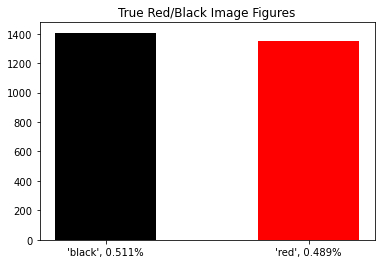

1    291
0    261
dtype: int64


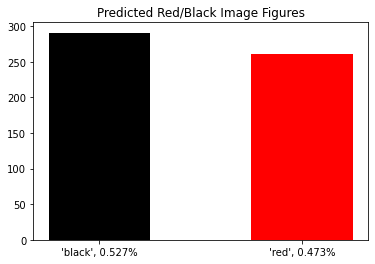

In [19]:
y_pred = logit.predict(X_test)
true_values= y.value_counts()
pred_values = pd.Series(y_pred.T).value_counts()
plot_binary(true_values,False)
plot_binary(pred_values,True)

So our true values slightly lean towards being black. And our predicted values follow the same pattern!

And view some of the guesses...

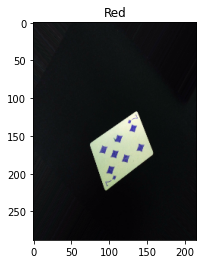

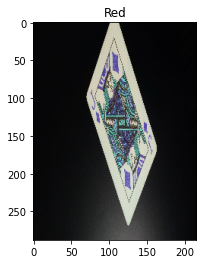

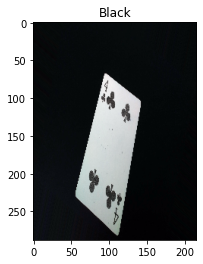

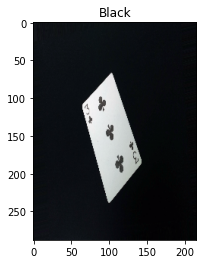

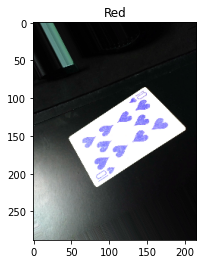

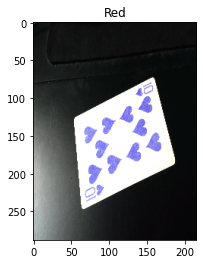

In [20]:
for i in range (0,6):
    prediction = int(logit.predict([X_test.iloc[i,:]]))
    color = ''
    if(prediction == 1):
        color = 'Red'
    if(prediction == 0):
        color = 'Black'
    plt.title(color)
    plt.imshow(np.array(X_test.iloc[i,:]).reshape(288,216,3))
    plt.show()

## Accuracy Insights - Recall, Precision and F1 Score

Let's delve a bit deeper into our accuracy. The confusion matrix reveals where our model succeeded and failed.

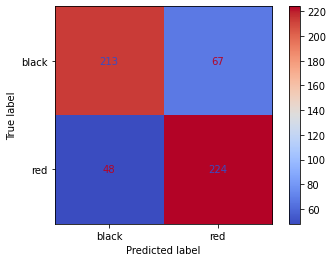

In [21]:
from sklearn.metrics import confusion_matrix,plot_confusion_matrix

plot_confusion_matrix(logit,X_test,y_test,cmap = 'coolwarm',display_labels= ['black','red'])
plt.show()

TP = confusion_matrix(y_test,y_pred)[0,0]
TN  = confusion_matrix(y_test,y_pred)[1,1]
FP  = confusion_matrix(y_test,y_pred)[1,0]
FN  = confusion_matrix(y_test,y_pred)[0,1]


In the upper left, we have *True Negatives (TN)*. This is when the color was not red (0) and our model predicted not red. In the lower right quadrant, we have *True Positives (TP)*. Our model predicted red (1) and the card was red. 

The more insightful figures are the incorrect answers: the bottom left quadrant is *False Positives (FP)*. Our model predicted red (1 or true) but was incorrect. Naturally, the last quadrant is *False Negatives (FN)*, when our model predicted false but was incorrect.

These figures can generate more specific types accuracy scores. The precision score is the ratio $$\frac{TP}{TP+FP}$$. In other words, this is the percentage of true positive guesses that were correct compared to total positive guesses.

In [22]:
precision = TP /(TP + FP)
print(f'The precision score is {precision}')

The precision score is 0.8160919540229885


The recall score is the ratio $$\frac{TP}{TP+FN}$$. This is percentage of true positive guesses over actual positive entries.

In [23]:
recall = TP /(TP + FN)
print(f'The precision score is {recall}')

The precision score is 0.7607142857142857


Finally, the F1 score is the harmonic mean of the precision and recall scores. That is $$2*\frac{precision*recall}{precision+recall}$$

In [24]:
f1 = 2*((precision*recall)/(precision+recall))
print(f'The F1 score is {f1}')

The F1 score is 0.7874306839186691


These 3 scores give a more comprehensive view of model performance.

## PCA


When working with many features it often using Principle Component Analysis (PCA) is usually beneficial. PCA is 
> a dimensionality-reduction method that is often used to reduce the dimensionality of large data sets, by transforming a large set of variables into a smaller one that still contains most of the information in the large set. [source](https://builtin.com/data-science/step-step-explanation-principal-component-analysis)

This is done by taking the one or multiple principle components, or elements of a matrix that contain the most variance. PCA is not foolproof; oftentimes, PCA is reducing this feature space at the cost of accuracy. Now, PCA will be applied to this dataset and the resulting tradeoff will be explored. A PCA object will be instantiated and fit on the training set, before transforming the training and test sets.

In [25]:
from sklearn.decomposition import PCA # import PCA

#instantiate and fit to our X_train
my_PCA = PCA()
my_PCA.fit(X_train)

# transform X_train and X_test
X_train_PCA = my_PCA.transform(X_train)
X_test_PCA = my_PCA.transform(X_test)


Without defining a `n_components` for our PCA model, it simply returns the existing number of features. In this case, it is 2205 (same number of features as our training set: $2757*.2 ≈ 2205$ ). Now, we can view the amount of variance explained by fitting a PCA transformation to our data. This can show us an optimal number to transform to. We should expect a scree (or elbow) plot where there is a sharp inward curve when reaching the optimal values.

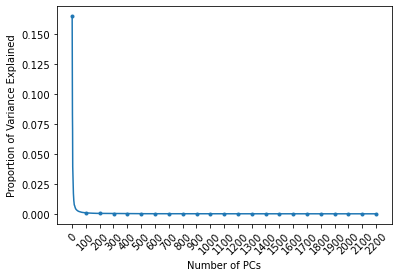

In [26]:
# the variance
expl_var = my_PCA.explained_variance_ratio_

# view in a plot
plt.figure()
plt.plot(range(1,2205),expl_var,marker='.',markevery=100)
plt.xlabel('Number of PCs')
plt.ylabel('Proportion of Variance Explained')
plt.xticks(range(0,2205,100), rotation= 45)
plt.show()

So plotting the whole range of values is not helpful. Although, it is clear that the inward curve occurs within the first 100 components. Let's zoom in.

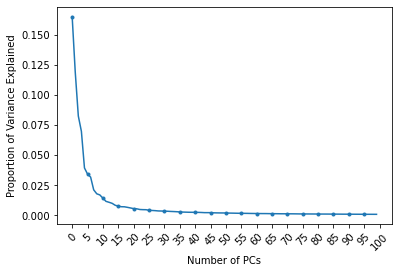

In [27]:
plt.figure()
plt.plot(range(0,100),expl_var[:100],marker='.',markevery=5)
plt.xlabel('Number of PCs')
plt.ylabel('Proportion of Variance Explained')
plt.xticks(range(0,101,5), rotation= 45)
plt.show()

From this graph, it looks like a number of components value of approx. 30 is optimal. After this, no more variance is explained by more principle components. We will run with this value...

In [28]:
my_PCA = PCA(n_components = 30)
my_PCA.fit(X_train)

# transform data 
X_train_PCA = my_PCA.transform(X_train)
X_test_PCA = my_PCA.transform(X_test)



In [29]:
potential_c = [10**i for i in range(-5,5)]
print(potential_c)

[1e-05, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000]


Due to the drastically reduced feature space, we are able to test way more hyperparameters for our LogReg model without fear of running into memory depletion issues.

In [30]:
grid={"C":potential_c,"penalty":["l1","l2"],"solver":['newton-cg', 'lbfgs', 'liblinear']}
logreg=LogisticRegression()
logreg_cv=GridSearchCV(logreg,grid,cv=5)

fitted_search  = logreg_cv.fit(X_train_PCA,y_train)

fitted_search.best_estimator_,fitted_search.best_score_,fitted_search.best_params_

(LogisticRegression(C=0.1, solver='liblinear'),
 0.6619882498453926,
 {'C': 0.1, 'penalty': 'l2', 'solver': 'liblinear'})

So, it is clear that PCA transformation striped a large amount of accuracy away from our model. This is undoubtedly due to the sheer scope of downsizing we are doing. We are converting about 180,000 pixels into 30. This is shrinking our original data by a rate of 6000! When that is put into perspective, losing only ~14 accuracy points is still incredible. However, Going forward, we will not transform our data in this way because we aim to get the highest accuracy possible. 

In the next notebook, we will introduce new models that are compatible with multiclass classification. Instead of predicting a card's color, we will predict the suit. That upgrades our classes from 2 to 4. 